In [15]:

import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    ModelVisualizer,
    Parser,
    Simulator,
    StartMeshcat,
    ModelInstanceIndex,
    BodyIndex,
    MultibodyPlant,
    RigidTransform
)

from underactuated import (
    running_as_notebook,
    ConfigureParser,
)



from manipulation.scenarios import AddMultibodyTriad

from underactuated.meshcat_utils import AddMeshcatTriad

import Simulation as sim
import FixedWing as fw
from pydrake.geometry import MeshcatVisualizer, SceneGraph
import pydot


from IPython.display import SVG, display



In [16]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [17]:
## load the plane model

PLANE_URDF_PATH = "DeltaWingModel/urdf/DeltaWing.urdf"


with open(PLANE_URDF_PATH, 'r') as file:
    deltawing_urdf = file.read()


In [18]:
visualizer = ModelVisualizer(meshcat=meshcat)
parser = visualizer.parser()
parser.package_map().PopulateFromFolder("DeltaWingModel")

parser.package_map().GetPath("DeltaWingModel")


'DeltaWingModel/'

In [19]:

parser.AddModelsFromString(deltawing_urdf, "urdf")
visualizer.Run(loop_once=not running_as_notebook)
meshcat.Delete()
meshcat.DeleteAddedControls()

INFO:drake:Click 'Stop Running' or press Esc to quit


In [20]:
def draw_frames(plant, scene_graph):

    for body_name in [
        "base_link",
        "right_motor",
        "left_motor",
        "right_elevon",
        "left_elevon"
        
    ]:
        
        AddMultibodyTriad(plant.GetFrameByName(body_name), scene_graph)
        
        frame = plant.GetFrameByName(body_name)
        print(f"frame for {body_name} added: {frame}")
        
        frame_id = plant.GetBodyFrameIdOrThrow(frame.body().index())
        print(f"frame id: {frame_id}")
        
        
        # print(f"frame for {body_name} added: {plant.GetFrameByName(body_name)}")
     
    # for i in range(plant.num_model_instances()):
    #     model_instance = ModelInstanceIndex(i)
    #     model_instance_name = plant.GetModelInstanceName(model_instance)

    #     camera_list = [f"camera_{s}" for s in range(3)]
    #     if(model_instance_name in camera_list):
    #         AddMultibodyTriad(plant.GetFrameByName(r"base", model_instance), scene_graph)
    

In [21]:
def print_model_instances(plant):
    # Iterate over all model instances in the plant
    for i in range(plant.num_model_instances()):
        model_instance = ModelInstanceIndex(i)
        model_instance_name = plant.GetModelInstanceName(model_instance)
        print(f"Model Instance: {model_instance_name}")

        # Get all body indices for the current model instance
        body_indices = plant.GetBodyIndices(model_instance)

        # Iterate over all body indices and print their names
        for body_index in body_indices:
            body = plant.get_body(BodyIndex(body_index))
            print(f"  Body Name: {body.name()}")

Model Instance: WorldModelInstance
  Body Name: world
Model Instance: DefaultModelInstance
Model Instance: DeltaWing
  Body Name: base_link
  Body Name: right_motor
  Body Name: left_motor
  Body Name: right_elevon
  Body Name: left_elevon
frame for base_link added: <RigidBodyFrame name='base_link' index=1 model_instance=2>
frame id: <FrameId value=487>
frame for right_motor added: <RigidBodyFrame name='right_motor' index=2 model_instance=2>
frame id: <FrameId value=494>
frame for left_motor added: <RigidBodyFrame name='left_motor' index=3 model_instance=2>
frame id: <FrameId value=501>
frame for right_elevon added: <RigidBodyFrame name='right_elevon' index=4 model_instance=2>
frame id: <FrameId value=508>
frame for left_elevon added: <RigidBodyFrame name='left_elevon' index=5 model_instance=2>
frame id: <FrameId value=515>

[BodyIndex(1), BodyIndex(2), BodyIndex(3), BodyIndex(4), BodyIndex(5)]
[<pydrake.multibody.plant.MultibodyPlant object at 0x7f19b55d6ef0>, <pydrake.geometry.SceneG

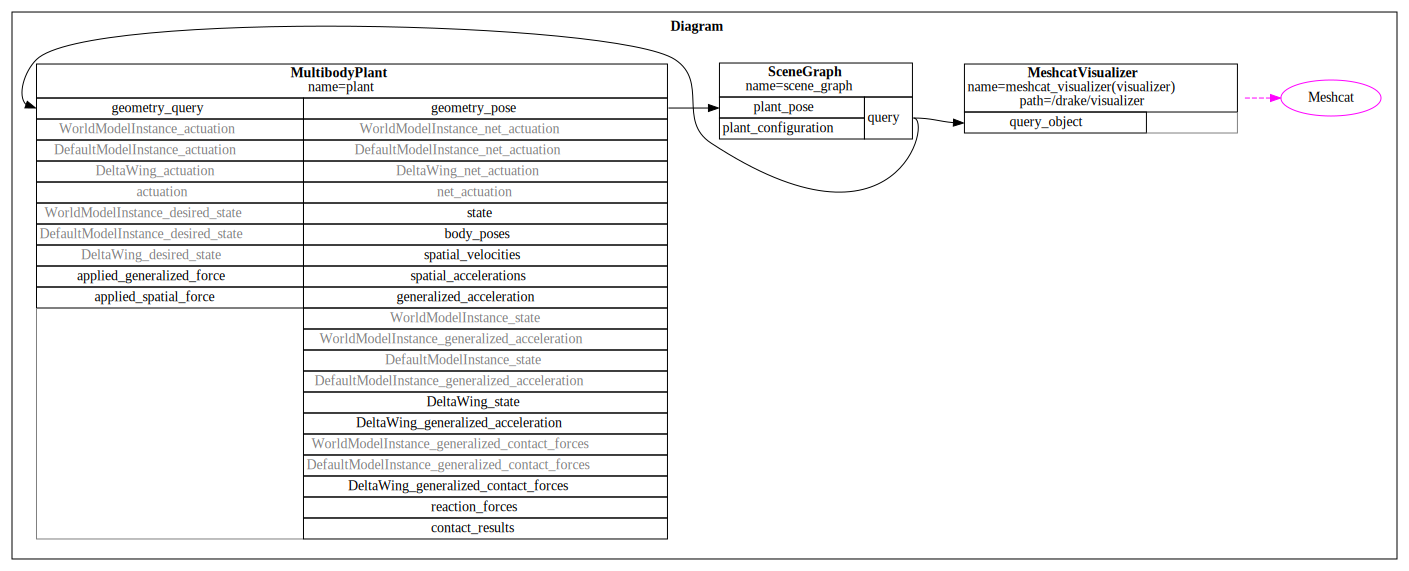

In [22]:
# simulator = sim.SimulationEnvironment("")
# simulator.connect_meshcat()
# simulator.add_fixed_wing()
# simulator.build_model()
# simulator.save_and_display_diagram()



builder = DiagramBuilder()
mbp, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0) # Time step doesn't matter, and this avoids a warning
parser = Parser(mbp, scene_graph)
parser.package_map().PopulateFromFolder("DeltaWingModel")

(model_id, ) = parser.AddModelsFromString(deltawing_urdf, "urdf")

mbp.Finalize()

MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)




# plane_sys = diagram.GetSubsystemByName("DeltaWing")



# plane_sys_context = diagram.GetMutableSubsystemContext(plane_sys, root_context)

# plane_context = diagram.GetMutableSubsystemContext(model_id, root_context)




print_model_instances(mbp)

draw_frames(mbp, scene_graph)



print()
print(mbp.GetBodyIndices(model_id))

# plane = builder.AddSystem(fw.FixedWingPlant())
# scene_graph = builder.AddSystem(SceneGraph())
# fw.FixedWingGeometry.AddToBuilder(builder, plane.GetOutputPort("state"), scene_graph)
# MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()

root_context = diagram.CreateDefaultContext()
x = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]) 
# plane_context.SetContinuousState(x)
diagram.ForcedPublish(root_context)

print(diagram.GetSystems())



svg = pydot.graph_from_dot_data(
                    diagram.GetGraphvizString(
                        max_depth=3))[0].create_svg()
svgdisplay = SVG(svg)

display(svgdisplay)





